In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', **{'size' : 18})

# Perceptronul multi-strat / Multi-Layer Perceptron (MLP)

## 1. Topologia reţelei

învăţarea se bazează tot pe ajustarea ponderilor în direcţia dată de gradientului negativ. De data aceasta funcţia de optimizat va avea ca argumente ponderie straturilor succesive. Vom pleca de la modelul reţelei pentru a da forma funcţiei de cost, care, vom vedea, poate fi privită ca o compunere de funcţii.

O reţea fully connected cu două straturi poate arăta, schematic, în felul următor:

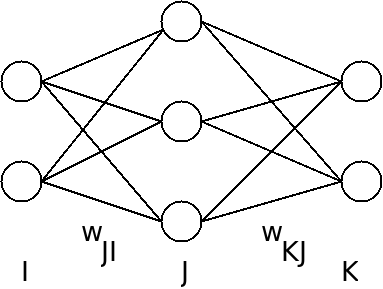

Primul strat, cel al intrărilor, este stratul $I$. Intrările vin dim matricea $X$ a sample-urilor, care are dimensiunea $(m, n)$. Primul set de ponderi este $w_{JI}$ (remarcaţi vă rog notaţia inversată). Acesta este conectat la stratul ascuns (hidden) $J$, cu activările $a_J$. Acestea se propagă prin ponderile $w_{KJ}$ către ultimul strat $K$.

Vom folosi $I$, $J$ şi $K$ atât pentru a referi primul, cel ascuns respectiv ultimul strat, cât şi pentru a le da o dimensiune. În exemplul considerat, pentru învăţarea setului MNIST cu 10 clase de digiţi, $I = 28 * 28 = 784$, dat de dimensiunea imaginii, $J=100$ (ales) iar $K=10$, dat de cele 10 clase de ieşire. Dimensiunea stratului ascuns ($J=100$) poate fi modificată; o dimensiune prea mică duce la performanţe slabe, în vreme ce o dimensiune prea mare îngreunează şi mai mult calculul (ar fi bine sa aveţi la dispoziţie minim 2GB RAM liberi).

Notând cu $a$ activările calculate şi cu $f(\cdot)$ funcţiile de activare (vor fi tanh respectiv softmax pentru ultimul strat), procesul de propagare înainte (forward propagation) poate fi scris concis sub forma următoare:

$a_I = X$

$a_J = f(z_J) = f(w_{JI} \cdot a_I + b_{JI})$

$a_K = f(z_K) = f(w_{KJ} \cdot a_J + b_{KJ})$

Folosim notaţia:

$net_K = z_K = w_{KJ} \cdot a_J$ 

pentru calcularea produselor scalare dintre liniile lui $w_{KJ}$ şi vectorul linie $a_J$; în realitate va fi o înmulţire de matrici. 

Activările $a_I$ şi $a_J$ vor fi de fapt matrici; $a_I$ ştim deja că este matricea $X$ de dimensiune $(m, n)$, unde $m=20$ va fi dimensiunea batch-ului iar $n = I = 28 * 28 = 784$; $a_J$ de dimensiune $(m, J) = (20, 100)$ iar $a_K$ de dimensiune $(m, K) = (20, 10)$. 

Ponderile straturilor vor avea dimensiunile: $w_{JI}$, $(J, I) = (100, 784)$ iar $w_{KJ}$, $(K, J) = (10, 100)$. $b_{JI}$ va fi de dimensiune $(100,)$ iar $b_{KJ}$ de dimensiune $(10,)$.

## 2. Calculul gradientului pentru ponderile ultimului strat

Funcţia de activare de pe ultimul strat este în cazul nostru $a_k = softmax(z_k)$. Ieşirea acesteia face obiectul funcţiei de cost, care este

$E(a_k) = crossentropy(a_k)$

Avem aşadar compunerea de funcţii

$E(w_{KJ}) = crossentropy(softmax(w_{KJ} \cdot a_J))$

Folosind chain rule, putem scrie derivata parţială a funcţiei de cost în raport cu ponderile de pe ultimul strat:

$\frac{\partial E}{\partial w_{kj}} = \frac{\partial E}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{kj}} = \frac{\partial E}{\partial a_k} \cdot \frac{\partial a_k}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{kj}} = crossentropy'(a_k) \cdot softmax'(z_k) \cdot a_j$

Relaţia se poate scrie mai compact ca:

$\nabla_{w_{KJ}} E = \delta_{a_K} \cdot a_J$, unde am notat vectorial:

$\delta_{a_K} = crossentropy'(a_K) \cdot softmax'(z_K)$

### Calculul lui $\delta_{a_K}$

Vom ţine seama de definiţia funcţiei cross entropy $E$:

$E(z, y) = - \sum_i y_i \log( softmax( z_i ))$

Revenind la notaţia pe o singură dimensiune, avem:

$\delta_{a_k} = \frac{\partial E}{\partial z_k} = - \frac{\partial}{\partial z_k} \left( \sum_i y_i \log(softmax(z_i)) \right) = - \sum_i y_i \frac{1}{softmax(z_i)} \frac{\partial}{\partial z_k} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right)$

Ultimul termen este derivata funcţiei $softmax$. Acesta necesită un tratament separat, pentru că $z_k$-ul după care se derivează poate să fie (sau nu) $z_i$-ul de la numitor:

a) pentru $k=i$:

$\frac{\partial softmax(z_i)}{\partial z_{k=i}} = \frac{\partial}{\partial z_i} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right) = softmax(z_i) \left[ 1 - softmax(z_i) \right]$

b) pentru $k \neq i$:

$\frac{\partial softmax(z_i)}{\partial z_{k}} = \frac{\partial}{\partial z_k} \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right) = - softmax(z_i) \cdot softmax(z_k)$

Revenind, $\delta_{a_k}$ devine:

$\delta_{a_k} = \frac{\partial E}{\partial z_k} = - \sum_{i \neq k} y_i \frac{1}{softmax(z_i)} (-1) softmax(z_i) \cdot softmax(z_k) - y_k \frac{1}{softmax(z_k)} softmax(z_k) \left[ 1 - softmax(z_k) \right] = softmax(z_k) \sum_i y_i - y_k = softmax(z_k) - y_k$

Adică:

$\delta_{a_K} = softmax(z_K) - y_K$, dacă scriem relaţia vectorial.

Puteţi găsi întregul raţionament detaliat [aici](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba).


### Revenirea la notaţie

Gradienţii devin astfel:

$\nabla_{w_{KJ}} E = \delta_{a_K} \cdot a_J$

$\nabla_{b_{KJ}} E = \delta_{a_K}$, cu

$\delta_{a_K} = softmax(z_K) - y_K$

De remarcat faptul că $\delta_{a_K}$ este un vector de $K$ elemente iar $a_J$ un vector de $J$ elemente; prin înmulţirea primului vector (coloană) cu al doilea vector (linie) se generează matricea $w_{KJ}$.

## 3. Calculul gradientului pentru ponderile stratului intermediar (regula propagării înapoi, backpropagation)

Ne interesează şi gradientul funcţiei de cost în raport cu ponderile stratului intermediar. Avem:

$\frac{\partial E}{\partial w_{ji}} = \sum_k \frac{\partial E}{\partial z_k} \cdot \frac{\partial z_k}{\partial w_{ji}} = \sum_k \delta_{a_k} \cdot \frac{\partial z_k}{\partial z_j} \cdot \frac{\partial z_j}{\partial w_{ji}} = \sum_k \delta_{a_k} \cdot w_{kj} \cdot f'(z_j) \cdot a_i = f'(z_j) \left[ \sum_k \delta_{a_k} w_{kj} \right] a_i = \delta_{a_j} \cdot a_i$

Vectorial, putem scrie expresia mai compact astfel:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$, respectiv:

$\nabla_{b_{JI}} E = \delta_{a_J}$, unde: 

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

La fel, de remarcat faptul că $\delta_{a_J}$ este un vector de $J$ elemente iar $a_I$ un vector de $I = n$ elemente; prin înmulţirea primului vector (coloană) cu al doilea vector (linie) se generează matricea $w_{JI}$.

## 4. Prelucrarea setului de date

In [ ]:
train_set = pd.read_csv('mnist_train.csv').values
test_set = pd.read_csv('mnist_test.csv').values

Procesarea presupune separarea primului element din fiecare linie ca fiind eticheta $y$. Vom face acelaşi lucru şi pentru setul de train şi pentru cel de test:

In [ ]:
train_x, train_y = train_set[:,1:], train_set[:,0]
test_x, test_y = test_set[:,1:], test_set[:,0]

# verificăm că setul de train este separat în sample-uri şi etichete:
assert train_x.shape == (59999, 784)
assert train_y.shape == (59999,)

# la fel şi pentru setul de test:
assert test_x.shape == (9999, 784)
assert test_y.shape == (9999,)

In [ ]:
def show_samples(x_set, y_set):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16], train_y[:16])

In [ ]:
def normalize(x):
    """
    Normalizarea înseamnă împărţirea cu 255
    
    Args:
        x: matricea feature-urilor, dimensiune m x n
    
    Returns:
        matricea cu valorile normalizate in in [0, 1], dimensiune m x n
    """
    return x/255

In [ ]:
# în urma normalizării depunem rezultatele în aceleaşi variabile (le suprascriem)

train_x=normalize(train_x)
test_x = normalize(test_x)

# valorile sample-urilor vor fi constrânse în intervalul [0, 1]
assert np.all(np.bitwise_and(train_x >= 0., train_x <= 1.))
assert np.all(np.bitwise_and(test_x >= 0., test_x <= 1.))

Deoarece folosim funcţia cross-entropy pentru antrenare, vom encoda cu 'one-hot encoding' etichetele. Matricea train_y se va transforma dintr-o matrice de dimensiune $(m, 1)$ în una de dimensiuni $(m, k)$, unde $k = 10$ (avem 10 clase).

In [ ]:
def single_hot(p, k):
    """ 
    Single-hot encoding converteste o eticheta, de exemplu 7, in [0 0 0 0 0 0 0 1 0 0]
    
    Args:
        p: pozitia pe care se pune "1"
        k: numarul total de clase (lungimea listei generate)
    
    Returns:
        lista de zero-uri cu pozitia p setata pe 1
    """
    vect=np.zeros(k)
    
    vect[p]=1
    return vect

def one_hot(set_y, k):
    """
    One-hot encoding converteste un intreg set la o forma matriciala.
    Foloseste implemetarea lui single-hot.
    
    Args:
        set_y: vector de dimensiune (m,)
        k: numarul de clase
        
    Returns:
        matricea de dimensiune (m, k), o linie reprezentind encodarea fiecarei etichete
    """

    return np.array([single_hot(set_y[index],k) for index in range(0,set_y.shape[0])])

train_y = one_hot(train_y, 10)

test_y = one_hot(test_y, 10)

# verificam dimensiunile
assert train_y.shape == (train_x.shape[0], 10)
assert test_y.shape == (test_y.shape[0], 10)

# verificam ca pe fiecare linie sa avem doar un 1 si restul zero-uri
assert np.all(train_y.sum(axis=1) == 1)
assert np.all(test_y.sum(axis=1) == 1)

În implementarea funcţiei de activare n-am mai folosit funcţia sigmoidă ca până acum, ci funcţia tangentă hiperbolică. Iată cum arată acestea:

In [ ]:
def represent():
    x = np.linspace(-10, 10, 100)
    sigmoid = lambda x: 1. / (1 + np.exp(-x))
    sigmoid_d = lambda x: sigmoid(x) * (1 - sigmoid(x))
    tanh = lambda x: np.tanh(x)
    tanh_d = lambda x: 1.0 - (tanh(x) ** 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.plot(x, sigmoid(x), '-', color='blue')
    ax.plot(x, sigmoid_d(x), '--', color='blue')
    ax.plot(x, tanh(x), '-', color='red')
    ax.plot(x, tanh_d(x), '--', color='red')
    ax.legend(['sigmoid(x)', "sigmoid'(x)", 'tanh(x)', "tanh'(x)"])
    ax.grid() ; plt.show()
    
represent()

Avem următoarele remarci:
* media funcţiei sigmoide este 0.5, faţă de 0.0 a lui tanh;
* media derivatei sigmoidei este 0.076 faţă de 0.154 a derivatei lui tanh.

Tangenta hiperbolică prezintă o serie de avantaje:

* tanh este simetrică faţă de 0. Inputurile sunt normalizate (adică în intervalul \[-1, 1\]), iar aplicarea ei va produce tot valori de ieşire în acest interval (valorile de ieşire sunt intrări pentru stratul următor);
* convergenţa este mai rapidă dacă toate activările reţelei au media zero şi dispersie 1, şi sunt decorelate.

Pentru o intrare negativă, ieşirea în cazul funcţiei sigmoide se saturează la 0. Acest lucru nu se întâmplă în cazul funcţiei tanh(), o intrare negativă determină o activare negativă. Prin acest comportament, funcţia sigmoidă poate determina reţeaua să se blocheze în minime locale, procesul de învăţare decurgând mai lent.

Mai multe detalii puteţi găsi în articolul lui [Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

## 5. Implementarea funcţiei softmax

In [ ]:
def sigmoid(z):
    return np.tanh(z)

def sigmoid_derivative(z):
    return 1.0 - (np.tanh(z) ** 2)

def softmax(z):
    result=np.sum(np.exp(z), axis=1)
    result=np.reshape(result,(-1,1))
    
    return np.exp(z)/result

    
# verificam ca softmax-ul sa fie calculat corect
a = np.array([[1., 3, 4], [2, 7, 3]])
assert a.shape == softmax(a).shape
assert np.all(np.abs(softmax(a).sum(axis=1) - 1) < 1e-6)
assert softmax(a).sum(axis=1).shape == (2,)
del a

## 6. Implementarea propagării înainte (forward)

Scopul este să evaluăm strat cu strat întreaga reţea, pornind de la intrare. Activările primului strat sunt chiar sample-urile setului de date $X$.

Se vor calcula net-urile (z-urile) pentru fiecare strat:

$z = w \cdot a + b$, respectiv activarile următoare:

$a = sigmoid(z)$, respectiv funcţia $softmax()$ pentru ultimul strat.

De exemplu, intrarea $a_I$ are dimensiunea $(m, I)$. Ponderile primului strat $w_{JI}$ au dimensiunea $(J, I)$, deci activarea $a_J = f(a_I \cdot w_{JI}^T + b_{JI}^T)$ va avea dimensiunea $(m, J)$ - vom folosi înmulţirea matricială pentru calculul net-ului $z_{J}$.

In [ ]:
def forward(set_x, weights, biases):
    """
    Propagarea înainte prin reţea, cu calcularea net-urilor şi activărilor.
    Atenţie că activările de pe ultimul strat se calculează cu funcţia softmax() în loc de sigmoid().
    
    Args:
        set_x: setul de intrare de dimensiune (m, I)
        weights: lista de matrici de ponderi
        biases: lista de vectori de termeni liberi
        
    Returns:
        activations: lista de activari
        nets: lista de net-uri (z)
    """
    activations=[set_x]
    nets=[]
    
    nets.append(np.matmul(set_x,np.transpose(weights[0]))+biases[0])
    nets.append(np.matmul(sigmoid(nets[0]),np.transpose(weights[1]))+biases[1])
    
    activations.append(sigmoid(nets[0]))
    activations.append(softmax(nets[1]))

    return activations, nets

# Pentru testare. luam intrarea de dimensiune (3, 25). 3 va fi dimensiunea batch size-ului,
# iar I=25 este numarul de neuroni de pe primul strat.
inputs = np.ones((3, 25)) * 0.5

# Stratul ascuns are J=10 neuroni iar ultimul (softmax) are K=4.
weights = [np.ones((10, 25)) * 0.2, np.ones((4, 10)) * 0.3]
biases = [np.ones((10,)) * 0.1, np.ones((4,)) * 0.1]

activations, nets = forward(inputs, weights, biases)

# Pentru 3 straturi, se vor calcula 3 activări şi 2 net-uri în cele două liste rezultate:
assert len(activations) == 3
assert len(nets) == 2

# Verificam forma activarilor
assert activations[0].shape == inputs.shape == (3, 25)
assert activations[1].shape == (3, 10)
assert activations[2].shape == (3, 4)
assert np.abs(np.linalg.norm(activations[0]) - 4.330127) < 1e-6
assert np.abs(np.linalg.norm(activations[1]) - 5.4171262) < 1e-6
assert np.abs(np.linalg.norm(activations[2]) - 0.8660254) < 1e-6

# Verificam forma net-urilor
assert nets[0].shape == (3, 10)
assert nets[1].shape == (3, 4)
assert np.abs(np.linalg.norm(nets[0]) - 14.2407865) < 1e-6
assert np.abs(np.linalg.norm(nets[1]) - 10.6246844) < 1e-6

## 7. Implementarea propagării înapoi (backward propagation)

Propagarea înapoi are drept scop calcularea gradientului pentru fiecare strat. Pentru aceasta, va trebui să determinăm $\delta$ asociat pentru fiecare strat începând de la ultimul.

Atenţie că aceşti $\delta$ nu sunt vectori coloană, ci matrici, cu prima dimensiune dimensiunea batch-ului şi a doua dimensiune dimensiunea stratului. Pe baza lui $\delta$ veţi determina gradientul, prin medierea folosind dimensiunea batch-ului (prima dimensiune).

O complicaţie din cauza dimensiunii batch-ului apare la următoarea relaţie:

$\delta_{a_J} = \left( \delta_{a_K} w_{KJ} \right) \odot f'(z_j)$

Aici, $\delta_{a_K}$ are dimensiunea $(m, K)$ iar prin înmulţirea cu $w_{KJ}$ se generează o matrice de dimensiuni $(m, J)$, aceleaşi cu cele ale lui $f'(z_j)$.

O a doua complicaţie apare tot din cauza dimensiunii batch-ului la relaţiile de calcul a gradientului:

$\nabla_{w_{JI}} E = \delta_{a_J} \cdot a_I$

Aici, $\delta_{a_J}$ are dimensiunea $(m, J)$ iar $a_I$, $(m, I)$. Pentru a înmulţi primii $m$ vectori coloană cu ceilalţi $m$ vectori linie, folosim batch matrix multiplication - înmulţire normală de matrici doar pentru ultimele două dimensiuni, pentru fiecare element din dimensiunea 0. Adică redimensionăm $(m, J) \rightarrow (m, J, 1)$ iar $(m, I) \rightarrow (m, 1, I)$, iar prin înmulţirea lor matricială obţinem $(m, J, I)$. Reducem prin mediere prima dimensiune.

In [ ]:
def backward(weights, biases, activations, nets, set_y):
    """
    Propagă delta spre intrarea reţelei începând de la ultimul strat
    
    Args:
        weights: lista de ponderi
        biases: lista de elemente libere
        activations: lista de activari, calculata de forward
        nets: lista de z-uri, calculata de forward
        set_y: etichetele, one-hot encodate
        
    Returns:
        delta_w, delta_b: update-urile gradientilor
    """
    # declara delta-urile
    delta_b = [np.zeros(b.shape) for b in biases]
    delta_w = [np.zeros(w.shape) for w in weights]

    
    delta = np.array([0, softmax(nets[1]) - set_y])
    inmult = np.matmul(delta[1],weights[1])
    delta[0] = inmult * sigmoid_derivative(nets[0])

    for i in range(1, len(activations)):
        l = 2 - i

        delta_reshaped = delta[l].reshape(delta[l].shape[0], delta[l].shape[1], 1)
        activations_reshaped = activations[l].reshape(activations[l].shape[0], 1, activations[l].shape[1])

        delta_w[l] = np.matmul(delta_reshaped , activations_reshaped).mean(axis=0)
        delta_b[l] = delta[l].mean(axis=0)

        assert delta_w[l].shape == weights[l].shape
        assert delta_b[l].shape == biases[l].shape

        
    return delta_w, delta_b

# declaram niste etichete de test si aplicam metoda
labels = one_hot(np.array([1, 0, 3]), 4)
delta_w, delta_b = backward(weights, biases, activations, nets, labels)

# verificam consistenta raspunsurilor
assert len(delta_w) == len(delta_b) == 2
assert delta_w[0].shape == (10, 25)
assert delta_w[1].shape == (4, 10)
assert delta_b[0].shape == (10,)
assert delta_b[1].shape == (4,)
assert np.linalg.norm(delta_w[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_w[1]) - 0.9028543) < 1e-6
assert np.linalg.norm(delta_b[0]) < 1e-15
assert np.abs(np.linalg.norm(delta_b[1]) - 0.2886751) < 1e-6

## 8. Calculul unui batch şi a acurateţii

Constă din propagarea înainte, propagarea înapoi, urmate de ajustarea ponderilor.

In [ ]:
def compute_batch(batch_x, batch_y, weights, biases, eta, lmbda):
    """ 
    Realizeaza cei doi pasi pentru fiecare batch in parte
    
    Args:
        batch_x: sample-urile de intrare
        batch_y: etichetele lor
        weights: lista cu ponderile reţelei
        biases: lista cu termenii liberi
        eta: rata de învăţare
        lmbda: parametrul de regularizare
        
    Returns:
        weights, biases: noile ponderi după actualizarea lor cu gradienţii calculaţi
    """
    activations, nets = forward(batch_x, weights, biases)
    delta_w, delta_b = backward(weights, biases, activations, nets, batch_y)

    # Pentru fiecare parametru din lista se realizeaza:
    # weight <-- weight - eta * (grad_w + lambda * weight)
    # bias <-- bias - eta * grad_b
    weights=[weights[index]-eta*(delta_w[index]+lmbda*weights[index]) for index in range(len(weights))]
    biases=[biases[index]-eta*delta_b[index]  for index in range(len(biases))]
    
    return weights, biases

Acurateţea presupune inspectarea etichetelor şi compararea lor cu rezultatul produs de reţea:

In [ ]:
def accuracy(set_x, set_y, weights, biases):
    """ 
    Calculeaza iesirea sub forma de one-hot encoding folosind feedforward(),
    si o foloseste pentru a numara cate sample-uri sunt antrenate corect
    
    Args:
        set_x: sample-urile, de dimensiune (m, n)
        set_y: etichetele, de dimensiune (m, k)
        weights: lista ponderilor reţelei
        biases: lista termenilor liberi
        
    Returns:
        procentul de sample-uri clasificate corect
    """
    # ... call forward()
    activations, nets= forward(set_x,weights,biases)
    max_activation=np.argmax(activations[2], axis=1)
    max_y=np.argmax(set_y, axis=1)
    res = max_activation==max_y
    return 100 * res.sum() / len(res)

assert np.abs(accuracy(inputs, labels, weights, biases) - 33.3333333) < 1e-6

## 9. Antrenarea reţelei şi evaluarea pe setul de test

In [ ]:
import random
sizes = [28 * 28, 100, 10]
scale = 1 / np.sqrt(train_x.shape[0])

weights = [np.random.normal(loc=0, scale=scale, size = (j, i)) for i, j in zip(sizes[:-1], sizes[1:])]
biases = [np.random.normal(loc=0, scale=scale, size = (i,)) for i in sizes[1:]]

eta = 0.2
batch_size = 20 # pentru aceasta dimensiune de batch, consumul de memorie este la 1.5 GB
lmbda = 0.001
epochs = 10

for epoch in range(epochs):
    # generarea unei permutari aleatoare a sample-urilor din set
    perm = np.arange(train_x.shape[0])
    np.random.shuffle(perm)
  
    
    # generarea batch-urilor folosind acea permutare aleatoare
    x_batches = [train_x[perm[index*20:(index+1)*20]] for index in range(train_x.shape[0]//20) ]
    y_batches = [train_y[perm[index*20:(index+1)*20]] for index in range(train_y.shape[0]//20) ]

    # rularea batch-urilor si schimbarea ponderilor retelei
    for (batch_x, batch_y) in zip(x_batches, y_batches):
        weights, biases = compute_batch(batch_x, batch_y, weights, biases, eta, lmbda)
        
    print(f'epoch: {epoch}, eta: {eta:.2f}, train accuracy: {accuracy(train_x, train_y, weights, biases):.2f}')
    
    eta *= 0.8

In [ ]:
# acuratetea pe setul de test
accuracy(test_x, test_y, weights, biases)

## 10. Challenge

Pentru a obţine nota maximă, realizaţi modelul de regresie.

Acesta presupune să:
* înlocuiţi funcţia de cost din cross-entropy în Mean Square Error (eroarea pătratică medie), $E=\|a_K - y_K\|^2$
* înlocuiţi funcţia de activare de pe ultimul strat din $softmax$ în $tanh$
* calculaţi derivata pentru funcţia MSE şi să reeevaluaţi formula pentru $\delta_K$, prin prisma funcţiilor schimbate MSE şi $tanh$
* recalculaţi etichetele $y$ să fie valori întregi şi nu one-hot encoding-uri
* reantrenaţi noua reţea obţinută
* evaluaţi reţeaua pe setul de test, cu $y$ schimbaţi ca mai sus
